In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import itertools
from os import path
import pickle
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn.gaussian_process as gp

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 13]

import pandas as pd
pd.options.display.width = 500

slam_node_colors = {'gmapping': 'orange', 'slam_toolbox': 'blue', 'hector_slam': 'cyan'}


In [2]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        return cache_dict['df']

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [3]:
# load data from cache and rename columns
# df_new_config = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache_backup_2021-05-10.pkl")
df_new_config = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")
df_many_odoms = load_cache("/home/enrico/ds/performance_modelling/output/slam_many_odoms/run_data_per_waypoint_cache.pkl")
df = df_new_config.append(df_many_odoms, ignore_index=True, sort=False)
# df = df_new_config

df.rename(inplace=True, columns={
    'trajectory_length_trajectory_length': 'trajectory_length',
    'waypoint_relative_localization_error_translation_error_final': 'translation_error',
    'waypoint_absolute_localization_error_absolute_translation_error_start': 'absolute_translation_error',
    'waypoint_relative_localization_error_rotation_error_final': 'rotation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs_cont',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr_cont',
    'waypoint_start_time': 'start_time_cont',
})

# refactor and extract additional parameters and metrics
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['beta'] = df['beta'].apply(lambda x: max(x))
df['norm_translation_error'] = df.translation_error / df.trajectory_length
df['run_id'] = df['run_folder'].apply(lambda x: path.basename(x))
df['waypoint_index'] = df.sort_values('start_time_cont').groupby(df.run_id).cumcount()
df['accumulated_trajectory_length_cont'] = df.sort_values('start_time_cont').groupby(df.run_id).trajectory_length.cumsum() - df.trajectory_length
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df['p'] = df.translation_error.apply(lambda x: x > 0.2)

# discretize continuous input metrics
df['tgs'] = pd.cut(df.tgs_cont, 5, labels=False)
df['lvr'] = pd.cut(df.lvr_cont, 10, labels=False)
df['start_time'] = pd.cut(df.start_time_cont, 10, labels=False)
df['accumulated_trajectory_length'] = pd.cut(df.accumulated_trajectory_length_cont, 10, labels=False)

# drop unnecessary datapoints
# df = df[(
#     ((df.slam_node == 'gmapping') | (df.slam_node == 'slam_toolbox')) & (df.linear_update == 0.5) #|
# #     (df.slam_node == 'hector_slam') & (df.linear_update == 0.4)
# )]
df = df[((df.slam_node == 'gmapping') | (df.slam_node == 'slam_toolbox')) & (df.linear_update == 0.5)]
df = df[df.trajectory_length > 1]
df = df[df.absolute_translation_error < 5]

# only keep necessary columns
robot_parameters = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
]
other_parameters = [
    'run_absolute_start_time',
    'session_id',
    'run_number',
    'run_id',
    'slam_node',
    'environment_name',
]
input_discretized_metrics = [
    'start_time',
    'accumulated_trajectory_length',
    'tgs',
    'lvr',
]
input_continuous_metrics = [
    'waypoint_index',
    'start_time_cont',
    'tgs_cont',
    'lvr_cont',
]
output_metrics = [
    'norm_translation_error',
    'absolute_translation_error',
    'p',
]
df = df[
    robot_parameters +
    other_parameters +
    input_discretized_metrics +
    input_continuous_metrics +
    output_metrics
]

mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

printmd("## Parameters and Their Values")
for c in robot_parameters + input_discretized_metrics + ['slam_node', 'environment_name',]:
    printmd("{:>35}".format(c), sorted(list(df[c].unique())))
    
len(df)

## Parameters and Their Values

               laser_scan_max_range [3.5, 8.0, 15.0, 30.0]

                 laser_scan_fov_deg [90, 180, 270, 359]

                               beta [0.0, 0.5, 1.0, 1.5, 2.0]

                         start_time [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

      accumulated_trajectory_length [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

                                tgs [0, 1, 2, 3, 4]

                                lvr [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

                          slam_node ['gmapping', 'slam_toolbox']

                   environment_name ['7A-2', 'airlab', 'fr079', 'office_b']

160223

In [4]:
def gp_univariate_model_and_plot(num_polynomial_features, output_metric, model_feature, feature_transform):
    model_agg = dict()
    model_all = dict()
    df_agg = dict()

    printmd("### Univariate Gaussian Process Regression Model")
    printmd(f"{'slam_node':>20} | {'r2':>7}")
    for slam_node in df.slam_node.unique():

        df_agg[slam_node] = df[df.slam_node == slam_node].groupby(model_feature).mean()[output_metric.name]
        X_agg = (feature_transform(np.array(list(df_agg[slam_node].index.values)))).reshape(-1, 1)
        y_agg = df_agg[slam_node].values

        kernel = gp.kernels.DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-100, 100000.0))
        gp_model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=False)
        model_agg[slam_node] = make_pipeline(StandardScaler(), PolynomialFeatures(num_polynomial_features, interaction_only=False), gp_model)
        model_agg[slam_node].fit(X_agg, y_agg);
#         kernel = gp.kernels.DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-100, 100000.0))
#         gp_model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=False)
#         model_agg[slam_node] = gp_model
#         model_agg[slam_node].fit(X_agg, y_agg);

        y_pred_agg = model_agg[slam_node].predict(X_agg)
        r2_agg = r2_score(y_agg, y_pred_agg)

        printmd(f"{slam_node:>20} | {r2_agg:+0.4f}")

    n = 100
    plt.figure(figsize=1.5*np.array([5, 5]))

    model_feature_ls = np.linspace(model_feature.min(), model_feature.max(), n)
    model_feature_values = model_feature.unique()

    X_predict = (feature_transform(model_feature_ls)).reshape(-1, 1)

    for slam_node in df.slam_node.unique():
        y_predict, y_std = model_agg[slam_node].predict(X_predict, return_std=True)
        plt.plot(model_feature_ls, y_predict, linewidth=3, color=slam_node_colors[slam_node], label=f"{slam_node}, pred")
        plt.fill_between(model_feature_ls, y_predict-y_std, y_predict+y_std, color=slam_node_colors[slam_node], alpha=0.5, label=f"{slam_node}, pred std")
        plt.plot(df_agg[slam_node].index.values, df_agg[slam_node].values, '--o', color=slam_node_colors[slam_node], label=f"{slam_node}, data")
    plt.xlim([model_feature.min(), model_feature.max()])
    plt.ylim([0.0, 0.4]) # 10.1*max(max(df_agg["slam_toolbox"].values), max(df_agg["gmapping"].values))])
    plt.xlabel(f"{model_feature.name.replace('_', ' ')}")
    plt.ylabel(f"{output_metric.name.replace('_', ' ')}")
    plt.legend()
    plt.grid()
    plt.show()

### Univariate Gaussian Process Regression Model

           slam_node |      r2

            gmapping | +0.9918

        slam_toolbox | +0.9703

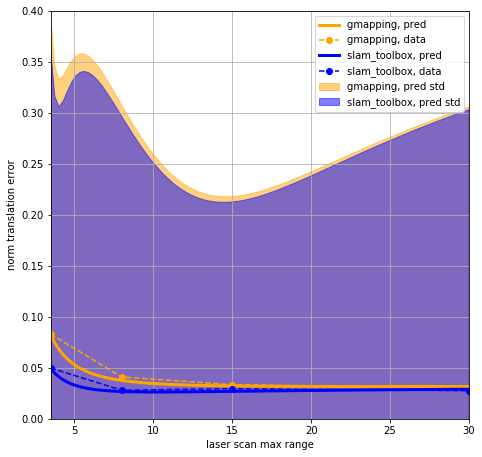

In [5]:
gp_univariate_model_and_plot(num_polynomial_features=2, output_metric=df.norm_translation_error, model_feature=df.laser_scan_max_range, feature_transform=lambda x: 1/x)

### Univariate Gaussian Process Regression Model

           slam_node |      r2

            gmapping | +0.9652

        slam_toolbox | +0.9893

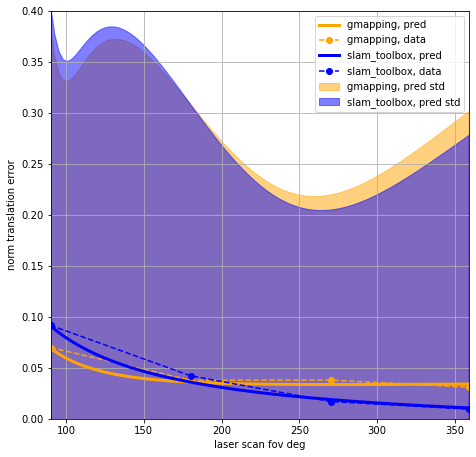

In [6]:
gp_univariate_model_and_plot(num_polynomial_features=2, output_metric=df.norm_translation_error, model_feature=df.laser_scan_fov_deg, feature_transform=lambda x: 1/x)

### Univariate Gaussian Process Regression Model

           slam_node |      r2

            gmapping | +0.9849

        slam_toolbox | +0.8815

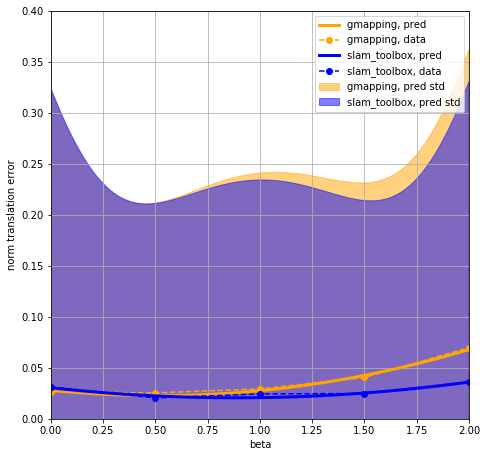

In [7]:
gp_univariate_model_and_plot(num_polynomial_features=2, output_metric=df.norm_translation_error, model_feature=df.beta, feature_transform=lambda x: x)

### Univariate Gaussian Process Regression Model

           slam_node |      r2

            gmapping | +0.9833

        slam_toolbox | +0.9891

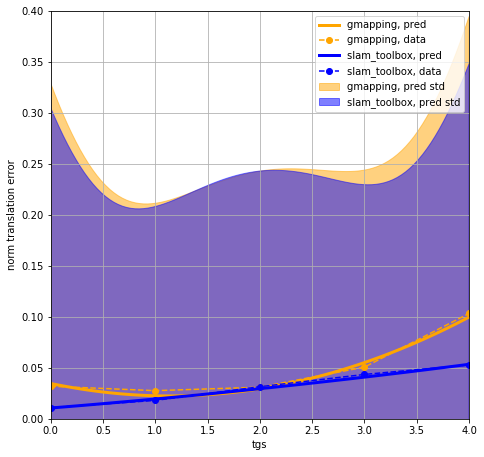

In [8]:
gp_univariate_model_and_plot(num_polynomial_features=2, output_metric=df.norm_translation_error, model_feature=df.tgs, feature_transform=lambda x: x)

### Univariate Gaussian Process Regression Model

           slam_node |      r2

/home/enrico/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


            gmapping | +0.9325

        slam_toolbox | +0.6108

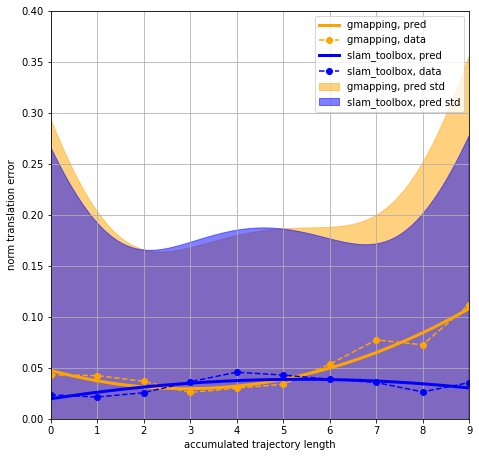

In [9]:
gp_univariate_model_and_plot(num_polynomial_features=2, output_metric=df.norm_translation_error, model_feature=df.accumulated_trajectory_length, feature_transform=lambda x: x)